In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box, Sequence, Dict
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from src.commons import methods
import statistics

from src.rl_environments.env_impr3 import EnvImpr3
from src.model_approaches.analytical.oracle_fix_n import OracleFix_n
from src.model_approaches.analytical.oracle_var_n import OracleVar_n
from src.model_approaches.analytical.pto_fix_n import PTO_Fix_n
from src.model_approaches.analytical.pto_var_n import PTO_Var_n
from src.model_approaches.rl.ppo import PPO

from src.commons import generate_data, methods
from src.commons.constants import AlphaEstimator, TravelTimeDist
import os
import pickle
from pathlib import Path

from collections import OrderedDict

## Train Config

In [2]:
PARAM_ESTIMATOR = AlphaEstimator.MAX_LIKELI

TRAIN_CONFIG = {
    'alpha_range': np.arange(0.1, 7.0, 0.1).tolist(),
    'beta_range': np.arange(0.1, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(5, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

PPO_TIME_STEPS = 2_000_000
PPO_ENV_CLASS = EnvImpr3


## Model Options

In [3]:
oracle_models = [OracleVar_n(), OracleFix_n(n=3), OracleFix_n(n=5)]
user_models = [PPO(EnvClass=EnvImpr3, config=TRAIN_CONFIG, timesteps=PPO_TIME_STEPS),
               PTO_Var_n(param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=3, param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=5, param_estimator=PARAM_ESTIMATOR)]

cost_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n', 'PTO_Fix_n_3', 'Oracle_Fix_n_3', 'PTO_Fix_n_5', 'Oracle_Fix_n_5'])
observed_n_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n'])

[INFO] Loaded trained PPO model from:
/Users/preetkaria/PycharmProjects/when_to_leave/models/PPO_EnvImpr3_c49ab_2M.zip


## Common Methods

In [4]:
def getResultColumnName(column: str, columns_to_visualize: list, type: str) -> str:
    for col in columns_to_visualize:
        if type in col and column in col:
            return col
    print(f"No matching column found for {column} with type {type}")

def testFlow(test_df_path: str, models: list):
    # Load test data
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)
    
    return test_df, columns_to_visualize

def evaluateResults(test_df: pd.DataFrame, columns_to_visualize: list, test_name: str, 
                    cost_results_df: pd.DataFrame, observed_n_results_df: pd.DataFrame):
    means = test_df[columns_to_visualize].mean()
    cost_results_row = {'Test Name': test_name}
    for cost_column in cost_results_df.columns:
        if cost_column == 'Test Name':
            continue
        mean_col = getResultColumnName(cost_column, columns_to_visualize, 'cost')
        cost_results_row[cost_column] = means.get(mean_col)
    cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
    
    observed_n_results_rows = {'Test Name': test_name}
    for observed_n_column in observed_n_results_df.columns:
        if observed_n_column == 'Test Name':
            continue
        mean_col = getResultColumnName(observed_n_column, columns_to_visualize, 'observed_n')
        observed_n_results_rows[observed_n_column] = means.get(mean_col)
    observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)
    
    return cost_results_df, observed_n_results_df

## Test on Simulated Data

In [5]:
base_sim_test = OrderedDict()
base_sim_test['low alpha from 0.1 to 1.0'] = {
    'alpha_range': np.arange(0.1, 1.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['medium alpha from 1.0 to 3.0'] = {
    'alpha_range': np.arange(1.0, 3.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high alpha from 3.0 to 5.0'] = {
    'alpha_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high beta from 3 to 5'] = {
    'alpha_range': np.arange(0.1, 3.0, 0.1).tolist(),
    'beta_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}
sim_tests = OrderedDict()
for travel_time in TravelTimeDist:
    for test_name, config in base_sim_test.items():
        new_test_name = f"{test_name} with {travel_time.name.lower()} travel time"
        new_config = config.copy()
        new_config['travel_time'] = travel_time
        sim_tests[new_test_name] = new_config


In [6]:
for test_name, config in sim_tests.items():
    print(f'Running test: {test_name}')
    
    test_df_path = generate_data.generate(config=config, row_count=10_000)
    
    pandarallel.initialize(progress_bar=True)
        
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in user_models + oracle_models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)

    cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)
    
    
        
        
    
    

Running test: low alpha from 0.1 to 1.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9f469_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 3.574522093224034
observed_n_PPO_EnvImpr3_c49ab_2M 5.3212
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 3.7194813534875713
observed_n_PTO_Var_n 4.967
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 6.7746872394557895
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 6.5273586532925245
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 2.684000854906536
observed_n_Oracle_Var_n 4.8471
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 3.001039962317077
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 4.373448664322476
Running test: medium alpha from 1.0 to 3.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/8b77a_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


cost_PPO_EnvImpr3_c49ab_2M 7.252628101649545
observed_n_PPO_EnvImpr3_c49ab_2M 8.2641
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 7.329798676173619
observed_n_PTO_Var_n 7.9036
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.281422909865526
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 10.957869792788037
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.556436956454888
observed_n_Oracle_Var_n 7.9934
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 6.897393458215554
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 7.56634815684398
Running test: high alpha from 3.0 to 5.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ffd47_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 9.97845757073854
observed_n_PPO_EnvImpr3_c49ab_2M 9.5677
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 9.901087376813313
observed_n_PTO_Var_n 9.164
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 15.818446454880876
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 14.106453079551406
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 7.5478384744375875
observed_n_Oracle_Var_n 9.2595
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 9.42848455615355
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 9.782163150978507
Running test: high beta from 3 to 5 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/c77a2_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 12.244643800471488
observed_n_PPO_EnvImpr3_c49ab_2M 8.3593
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 12.51478124829682
observed_n_PTO_Var_n 7.7694
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 17.705681167802844
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 15.840693517335003
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 9.80831868136985
observed_n_Oracle_Var_n 8.0676
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 11.826053445681284
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.953726112476057
Running test: low alpha from 0.1 to 1.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/81641_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 5.215055546408075
observed_n_PPO_EnvImpr3_c49ab_2M 7.1621
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 5.424209517908212
observed_n_PTO_Var_n 6.6543
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 8.59602409440539
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 7.809302011195719
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 4.463530809326172
observed_n_Oracle_Var_n 6.8409
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 5.077659145156908
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 5.584736852465018
Running test: medium alpha from 1.0 to 3.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0c4e9_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 6.842132421250701
observed_n_PPO_EnvImpr3_c49ab_2M 11.942
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.990708092567467
observed_n_PTO_Var_n 11.5333
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 13.582312865065445
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 11.91573803338581
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.69898149395608
observed_n_Oracle_Var_n 11.7451
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 7.937066902142204
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 7.968099419286577
Running test: high alpha from 3.0 to 5.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ad796_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 8.375272077338323
observed_n_PPO_EnvImpr3_c49ab_2M 13.3888
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 8.513526497143621
observed_n_PTO_Var_n 13.0273
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 17.12953132782111
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 14.990880479551036
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 7.139997895008829
observed_n_Oracle_Var_n 13.0591
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 10.479004166905101
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 10.377080753291786
Running test: high beta from 3 to 5 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/e425c_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 11.800394811222382
observed_n_PPO_EnvImpr3_c49ab_2M 11.6356
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 12.250266875292892
observed_n_PTO_Var_n 10.8625
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 20.486522755706957
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 17.947870724053974
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 10.091834655299925
observed_n_Oracle_Var_n 11.2235
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 13.420120594042638
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 13.229945708396269
Running test: low alpha from 0.1 to 1.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0b349_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 2.6670443634633667
observed_n_PPO_EnvImpr3_c49ab_2M 3.7564
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 2.808019084728821
observed_n_PTO_Var_n 3.5431
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 5.3491825318602375
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 7.8943361735728805
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 1.4221099941223765
observed_n_Oracle_Var_n 3.166
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 1.5790139641510341
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 6.407714495038476
Running test: medium alpha from 1.0 to 3.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f2aec_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 6.559097013939811
observed_n_PPO_EnvImpr3_c49ab_2M 4.3094
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.431956613572681
observed_n_PTO_Var_n 4.0825
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 9.771755401480293
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 10.83179184208528
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 4.575142699795806
observed_n_Oracle_Var_n 3.64
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 4.939406664560603
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 8.698052124205745
Running test: high alpha from 3.0 to 5.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/4556d_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 10.273187836653129
observed_n_PPO_EnvImpr3_c49ab_2M 4.7034
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 9.850498047892568
observed_n_PTO_Var_n 4.3814
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.745411171524006
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 12.96822160036584
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 7.50136672283199
observed_n_Oracle_Var_n 4.0063
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 8.044842247612237
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 10.58148780446012
Running test: high beta from 3 to 5 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/319b8_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 9.975929420747217
observed_n_PPO_EnvImpr3_c49ab_2M 4.6518
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 9.986478046856725
observed_n_PTO_Var_n 4.3364
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.923908743516282
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 12.985927173218188
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 8.519300892976995
observed_n_Oracle_Var_n 4.069
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 9.20744486772407
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.30218903247494


## Test Prof Data

In [7]:
test_df_path = Path(methods.file_path('prof_full_data.pkl', dir_name='data/prof_data_test/'))
test_name = "Prof Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)


# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 14.164906751126669
observed_n_PPO_EnvImpr3_c49ab_2M 16.4703
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 14.335176435521815
observed_n_PTO_Var_n 16.18
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 26.405796761524012
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 22.468632054456194
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


## Test Bicycle Data

In [8]:
test_df_path = Path(methods.file_path('bicycle_data.pkl', dir_name='data/non_gamma_bicyle_test'))
test_name = "Bicycle Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)
    
# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_c49ab_2M', 'observed_n_PPO_EnvImpr3_c49ab_2M']


cost_PPO_EnvImpr3_c49ab_2M 17.699372607982934
observed_n_PPO_EnvImpr3_c49ab_2M 36.12222222222222
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 18.69481590583333
observed_n_PTO_Var_n 35.41111111111111
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 34.33659797694444
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 29.870037397500003
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


In [9]:
display(cost_results_df.head())
display(observed_n_results_df.head())
cost_results_df.to_csv(methods.file_path('finla_test_cost_results.csv', dir_name='results'), index=False)
observed_n_results_df.to_csv(methods.file_path('finla_test_observed_n_results.csv', dir_name='results'), index=False)

,Test Name,PPO,PTO_Var_n,Oracle_Var_n,PTO_Fix_n_3,Oracle_Fix_n_3,PTO_Fix_n_5,Oracle_Fix_n_5
0,low alpha from 0.1 to 1.0 with uniform travel ...,3.574522,3.719481,2.684001,6.774687,3.001040,6.527359,4.373449
1,medium alpha from 1.0 to 3.0 with uniform trav...,7.252628,7.329799,5.556437,12.281423,6.897393,10.957870,7.566348
2,high alpha from 3.0 to 5.0 with uniform travel...,9.978458,9.901087,7.547838,15.818446,9.428485,14.106453,9.782163
3,high beta from 3 to 5 with uniform travel time,12.244644,12.514781,9.808319,17.705681,11.826053,15.840694,11.953726
4,low alpha from 0.1 to 1.0 with low travel time,5.215056,5.424210,4.463531,8.596024,5.077659,7.809302,5.584737


,Test Name,PPO,PTO_Var_n,Oracle_Var_n
0,low alpha from 0.1 to 1.0 with uniform travel ...,5.3212,4.9670,4.8471
1,medium alpha from 1.0 to 3.0 with uniform trav...,8.2641,7.9036,7.9934
2,high alpha from 3.0 to 5.0 with uniform travel...,9.5677,9.1640,9.2595
3,high beta from 3 to 5 with uniform travel time,8.3593,7.7694,8.0676
4,low alpha from 0.1 to 1.0 with low travel time,7.1621,6.6543,6.8409


## Average Cost Comparison Plot

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_uniform_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


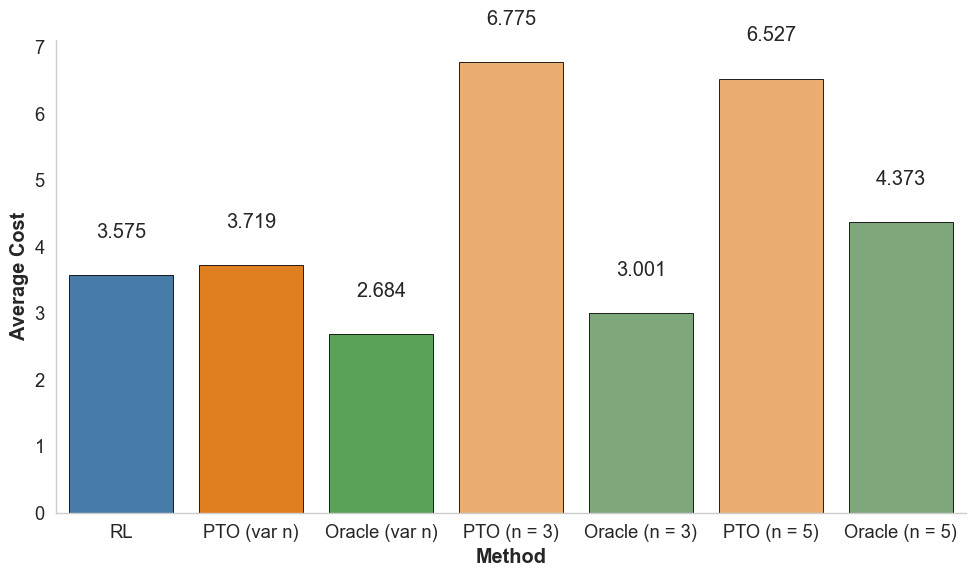

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_uniform_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


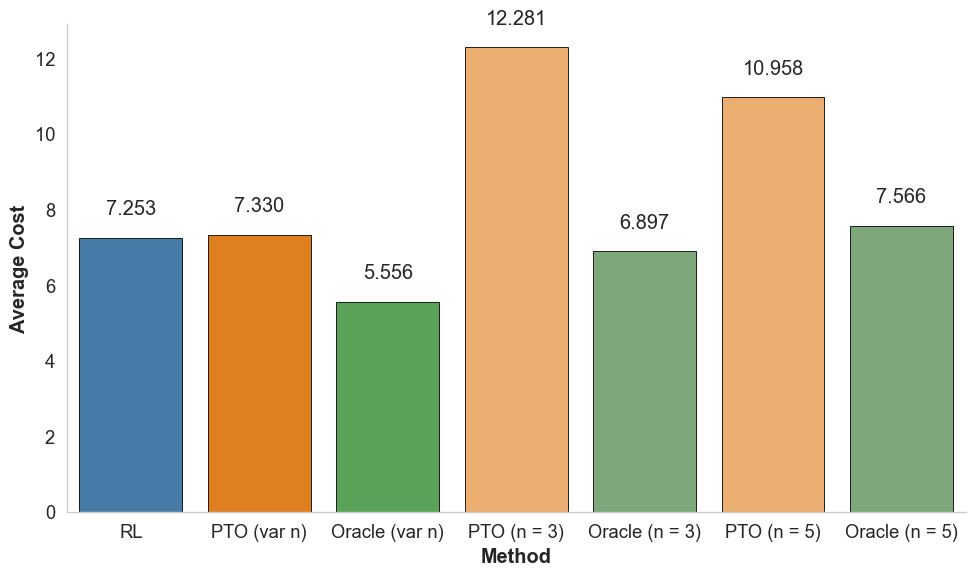

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_uniform_travel_time.png


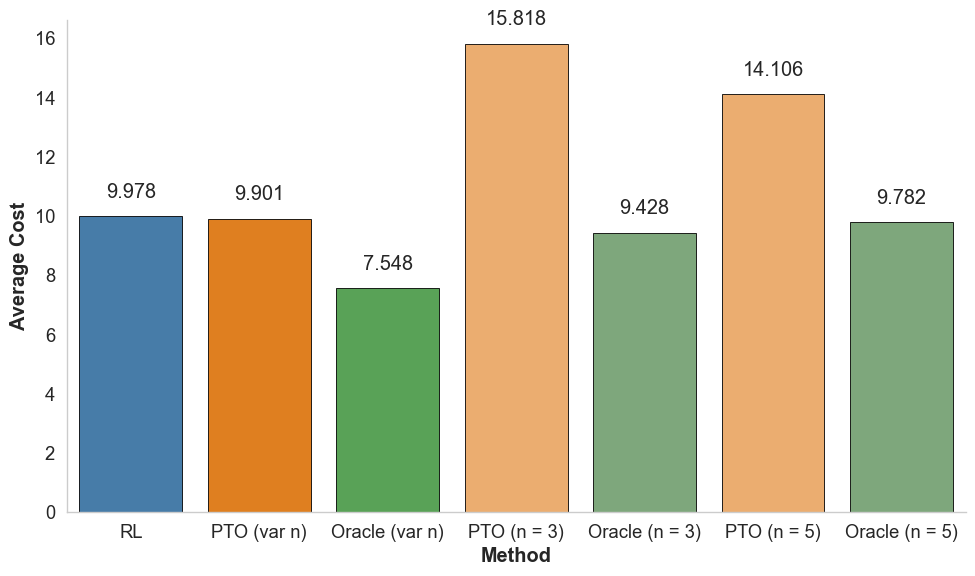

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_uniform_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


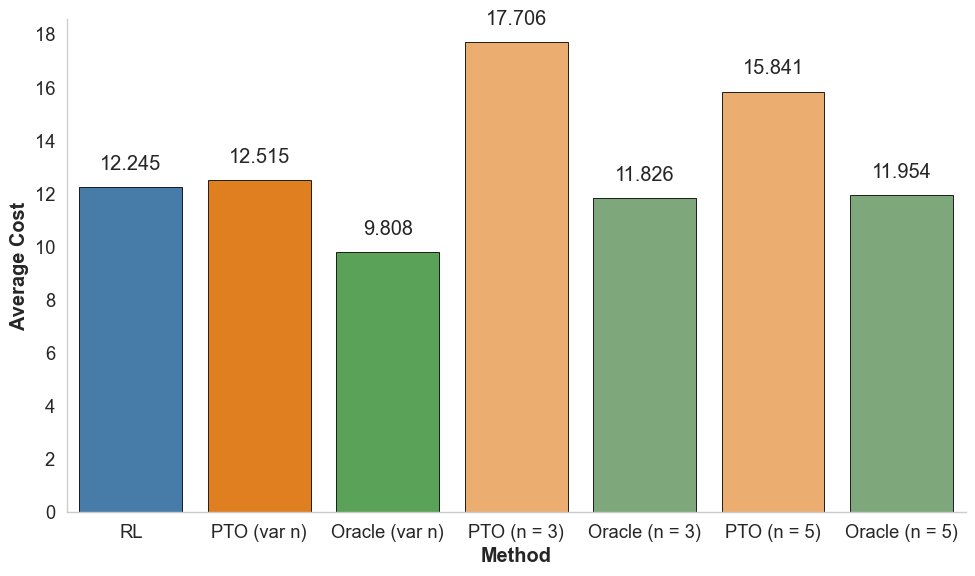

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_low_travel_time.png


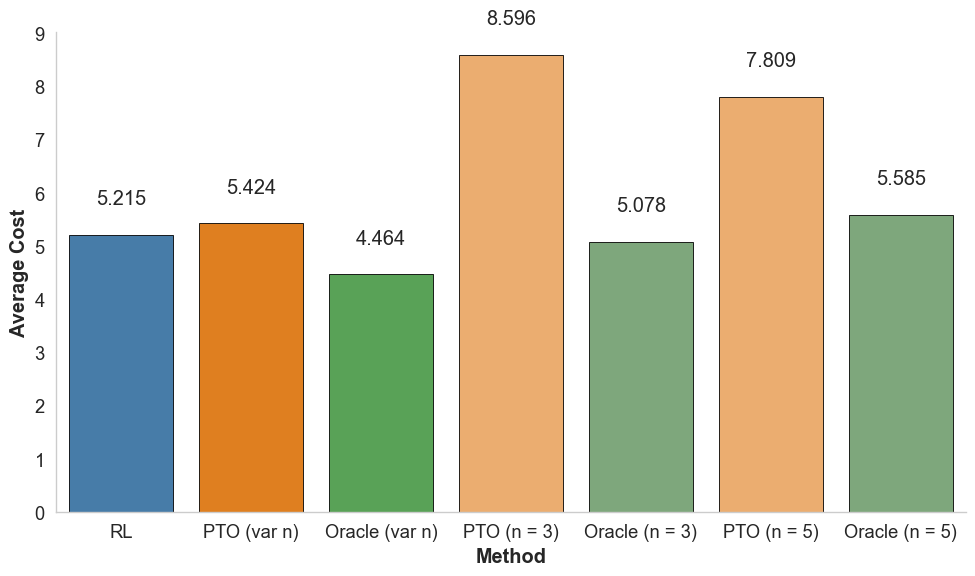

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_low_travel_time.png


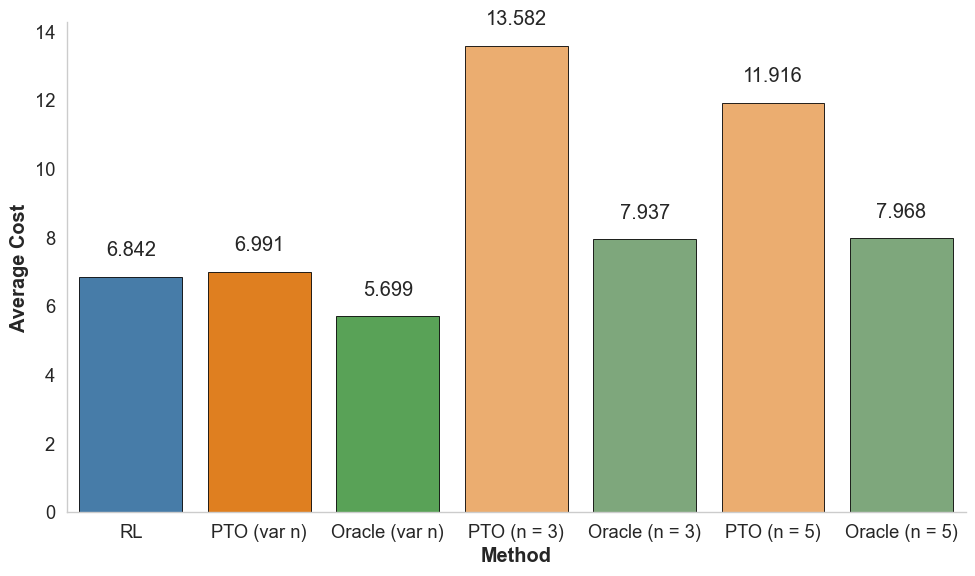

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_low_travel_time.png


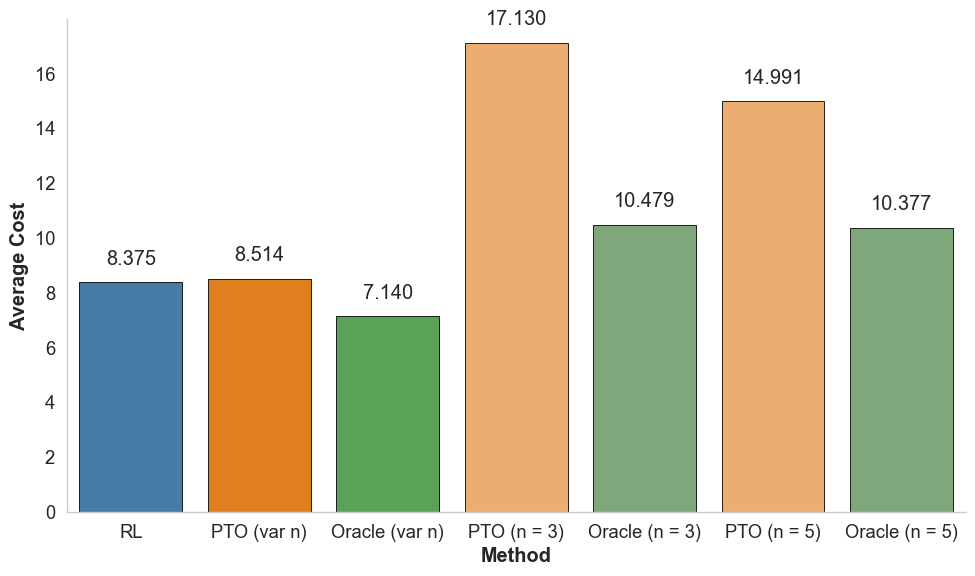

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_low_travel_time.png


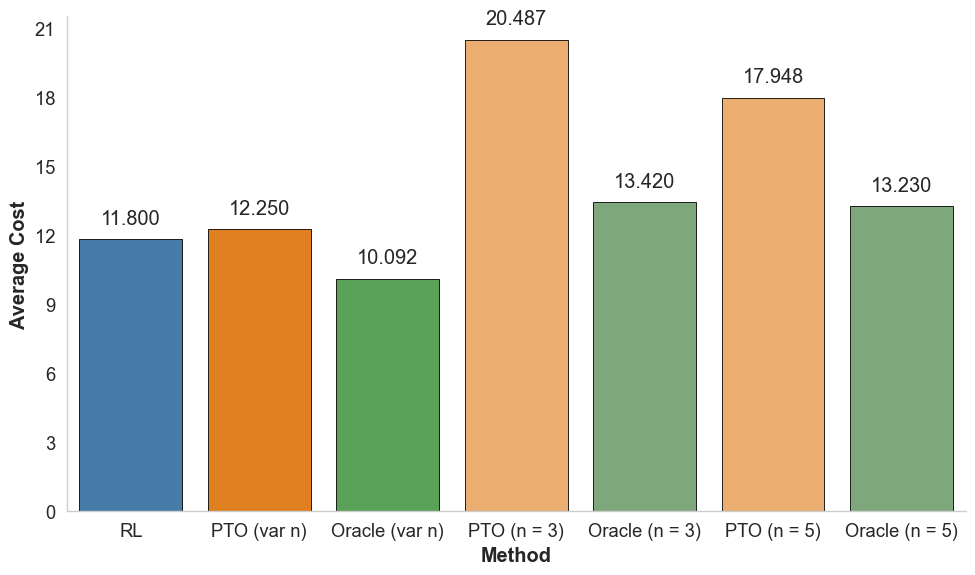

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_high_travel_time.png


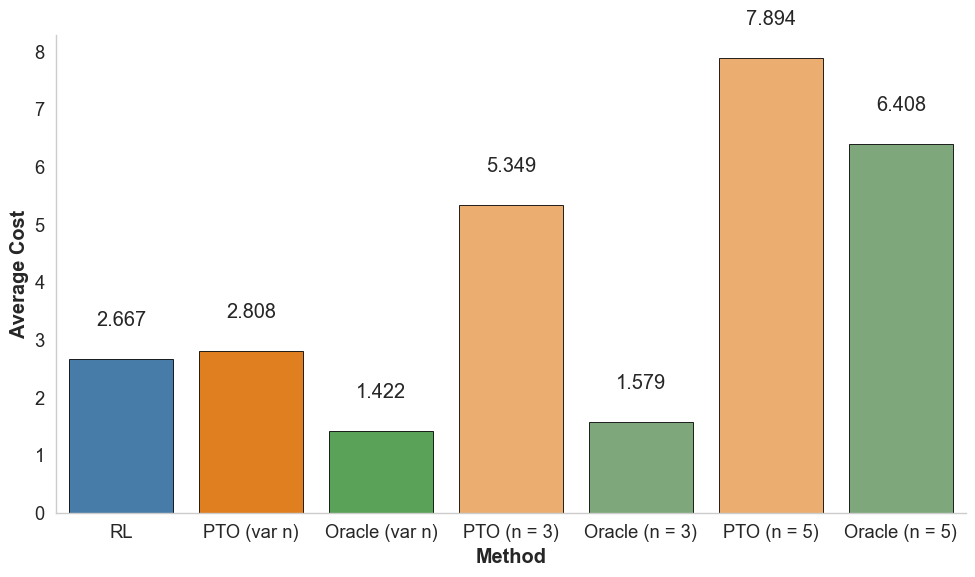

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_high_travel_time.png


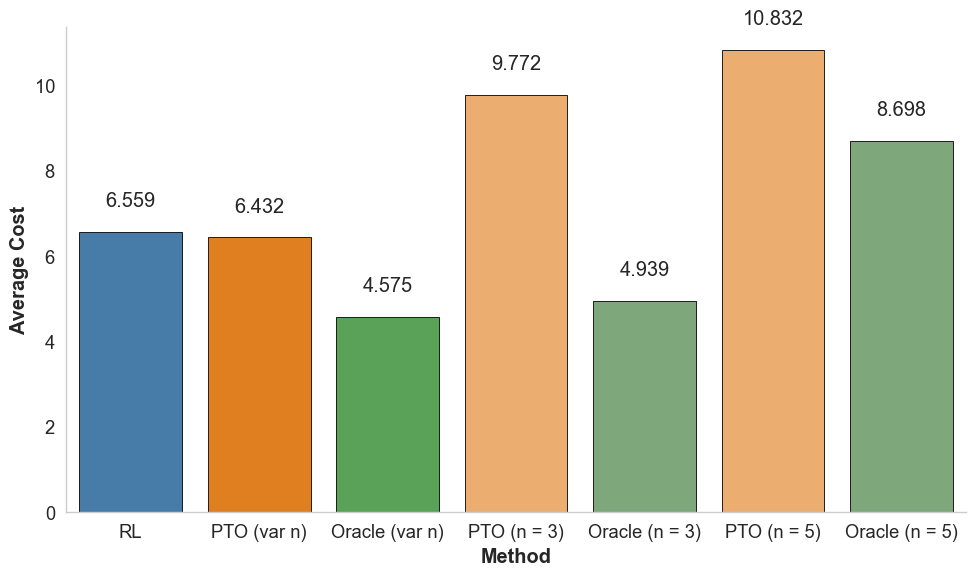

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_high_travel_time.png


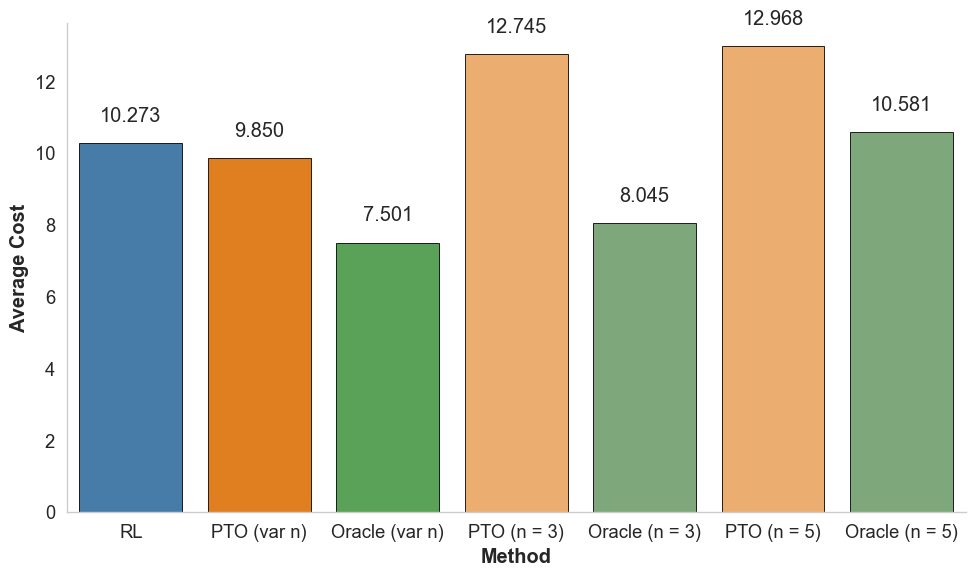

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_high_travel_time.png


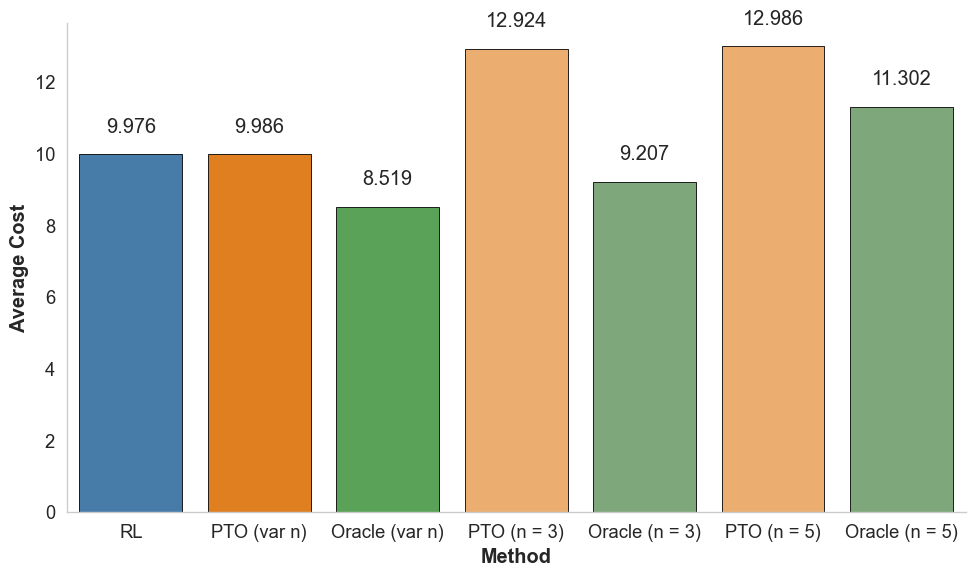

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_prof_data_test.png


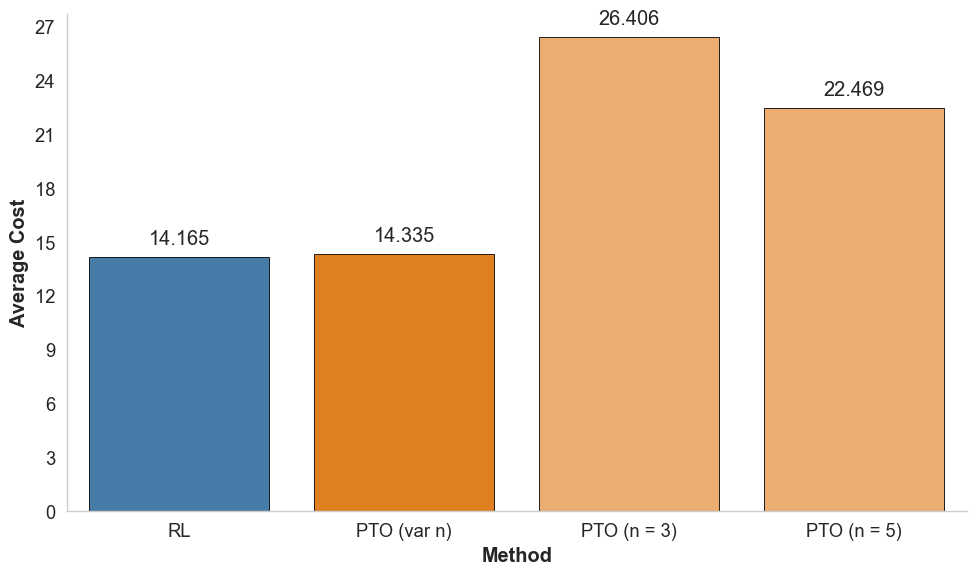

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/2838632569.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_bicycle_data_test.png


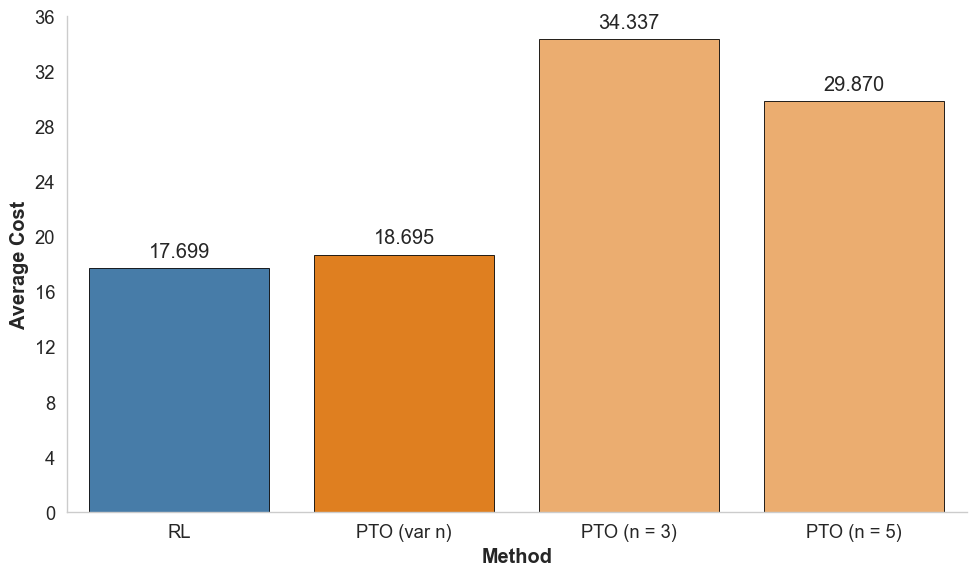

In [15]:
method_map = {'PPO': 'RL', 'PTO_Var_n': 'PTO (var n)', 'Oracle_Var_n': 'Oracle (var n)',
              'PTO_Fix_n_3': 'PTO (n = 3)', 'Oracle_Fix_n_3': 'Oracle (n = 3)',
              'PTO_Fix_n_5': 'PTO (n = 5)', 'Oracle_Fix_n_5': 'Oracle (n = 5)'}
color_map = {'PPO': '#377eb8', 'PTO_Var_n': '#ff7f00', 'Oracle_Var_n': '#4daf4a',
              'PTO_Fix_n_3': "#ffad5bff", 'Oracle_Fix_n_3': "#77ae75ff",
              'PTO_Fix_n_5': "#ffad5bff", 'Oracle_Fix_n_5': "#77ae75ff"}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import math
from matplotlib.ticker import MaxNLocator

sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})


for row in cost_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(cost_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n', 'PTO_Fix_n_3', 'PTO_Fix_n_5']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    costs = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average Cost')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(costs):
        ax.text(i, v + 0.5, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
   
    file_name = f'cost_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    print(f'Saved figure to {methods.file_path(f"{file_name}.png", dir_name="figures")}')
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Averge Cost Compiled

,Test Name,Method,Average Cost
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,3.574522
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,7.252628
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,9.978458
3,high beta from 3 to 5 with uniform travel time,PPO,12.244644
4,low alpha from 0.1 to 1.0 with low travel time,PPO,5.215056


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/4266817577.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


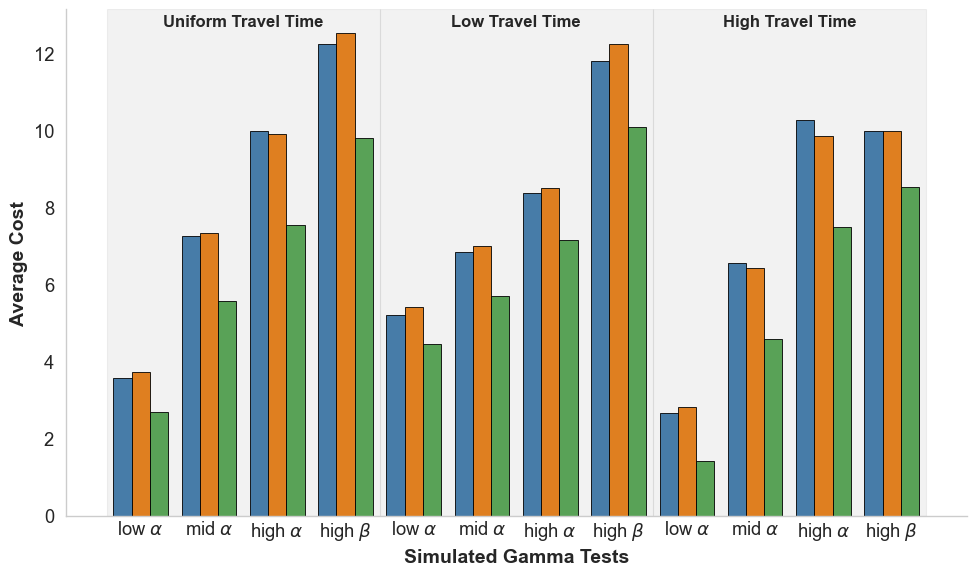

In [22]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
cost_results_df_melted = cost_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average Cost'
)
display(cost_results_df_melted.head())
cost_results_df_melted = cost_results_df_melted[
    cost_results_df_melted['Test Name'].str.contains('with', na=False)
    & ~cost_results_df_melted['Method'].str.contains('fix', case=False, na=False)
]
sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cost_results_df_melted,
    x='Test Name',
    y='Average Cost',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)
ax.set_ylabel('Average Cost', fontdict={'size': 14})
ax.set_xlabel('Simulated Gamma Tests', fontdict={'size': 14})
ax.set_xticklabels([
    r'low $\alpha$',
    r'mid $\alpha$',
    r'high $\alpha$',
    r'high $\beta$',  
] * 4)

# highlight groups: 1-4 uniform, 5-8 low, 9-12 high
group_spans = [
    (-0.5, 3.5, 'Uniform Travel Time'),
    (3.5, 7.5, 'Low Travel Time'),
    (7.5, 11.5, 'High Travel Time'),
]
for xmin, xmax, label in group_spans:
    ax.axvspan(xmin, xmax, color='grey', alpha=0.1, zorder=0)
    ax.text((xmin + xmax) / 2, ax.get_ylim()[1]*0.96, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]

# legend = ax.legend(handles, mapped_labels, title='Method')
# remove legend
_current_legend = ax.get_legend()
if _current_legend is not None:
    _current_legend.remove()

plt.tight_layout()
plt.savefig(methods.file_path('cost_comparison_compiled.png', dir_name='figures'))
plt.show()

# Average Obeserved n individual Plot

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


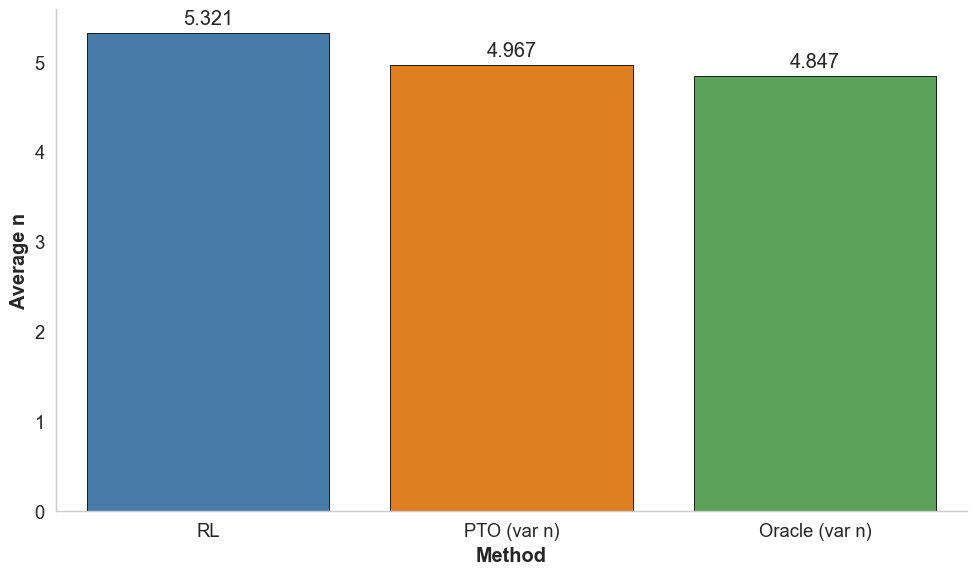

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


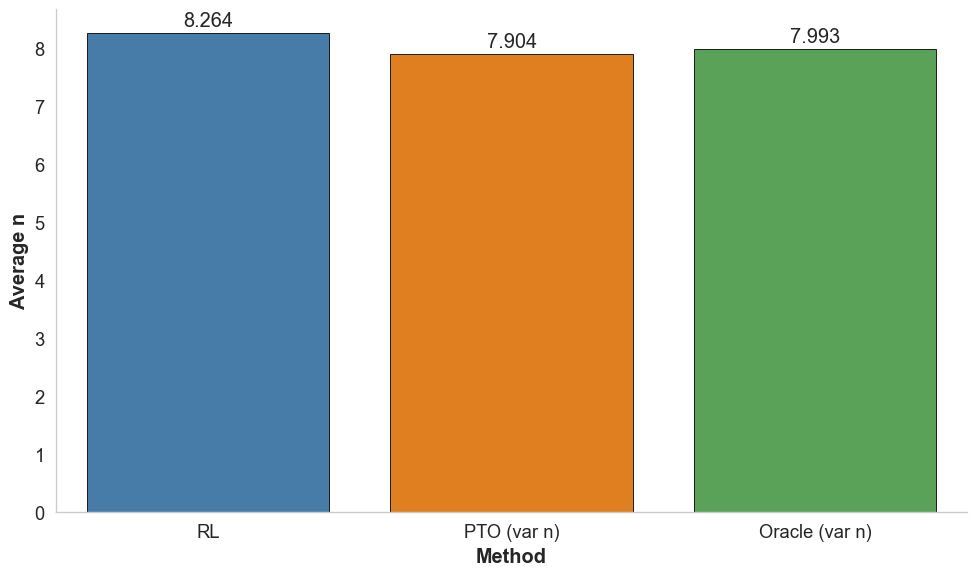

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


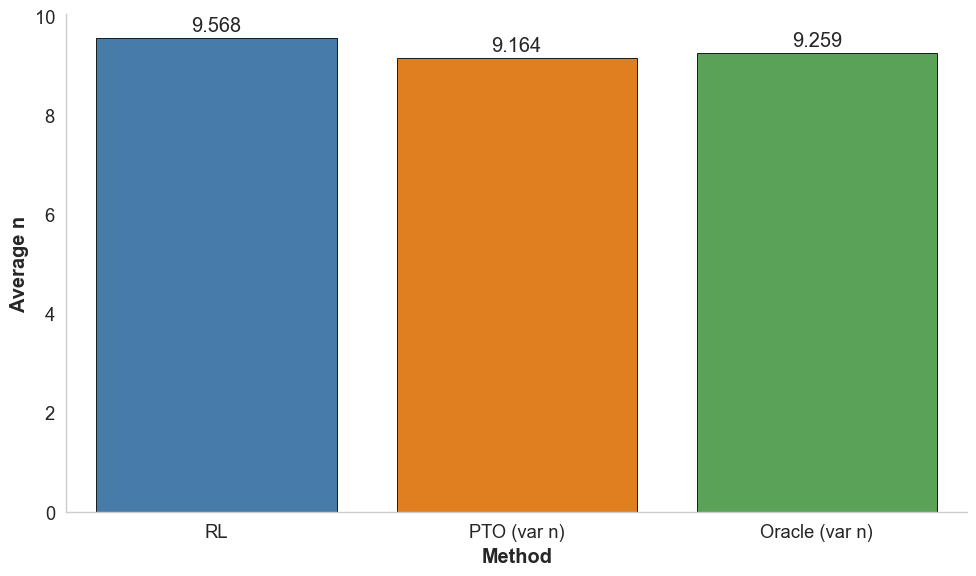

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


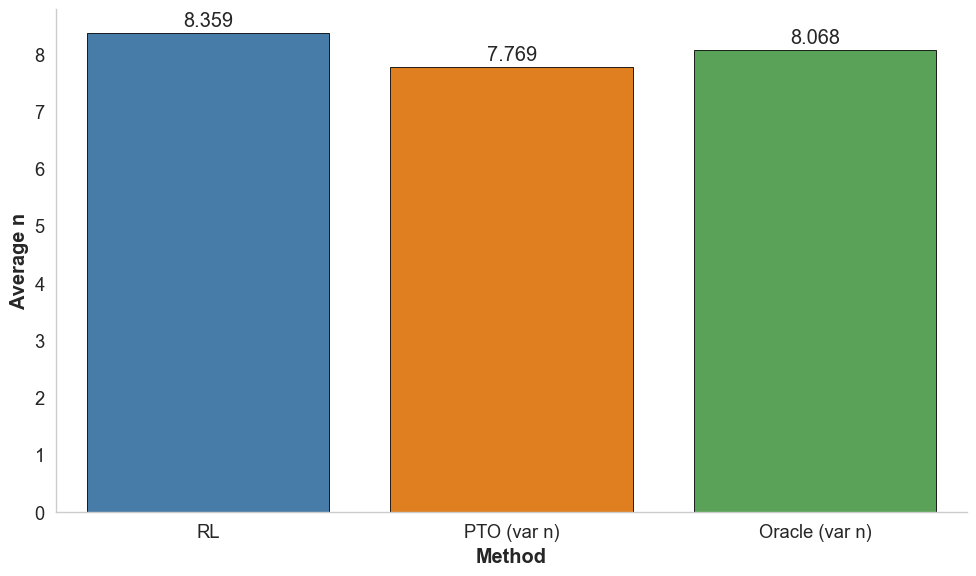

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


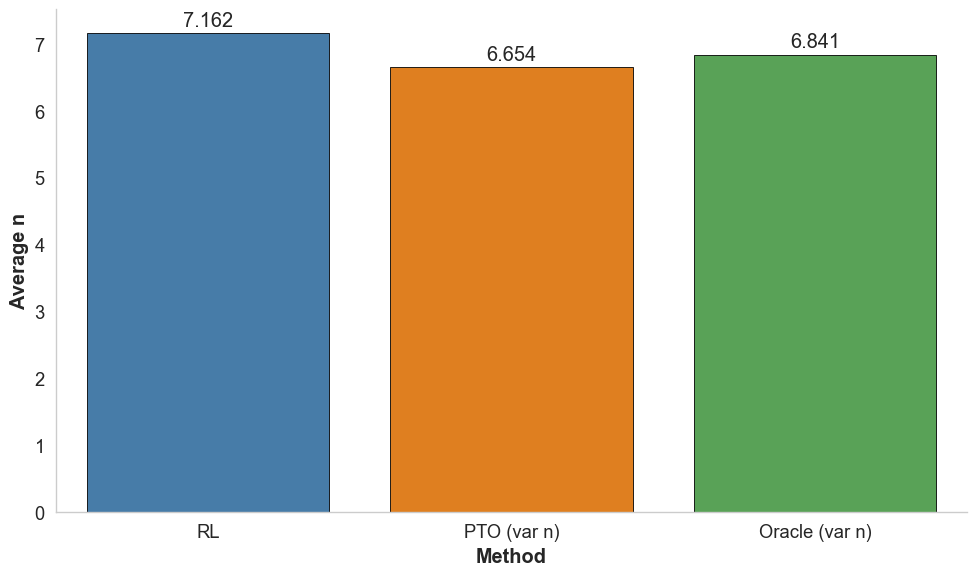

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


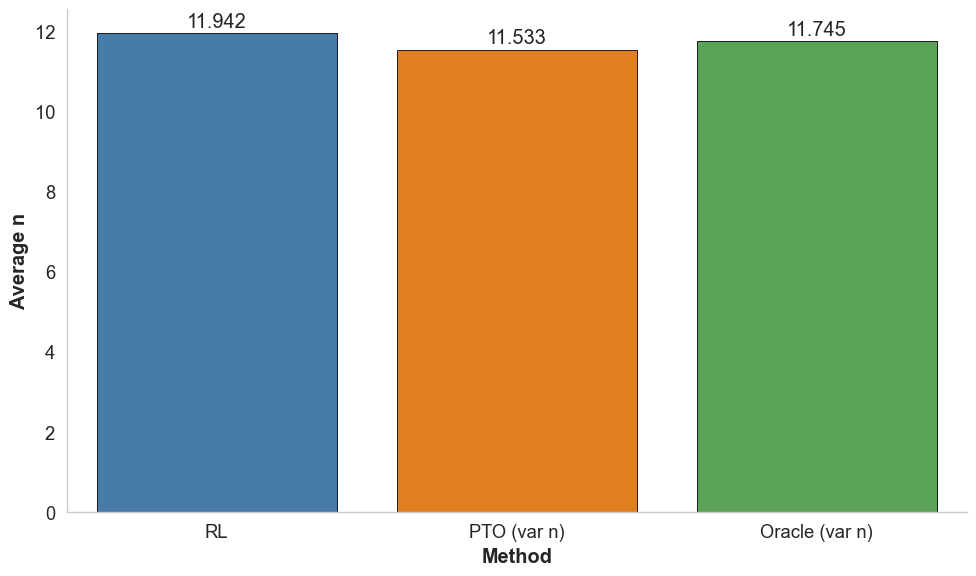

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


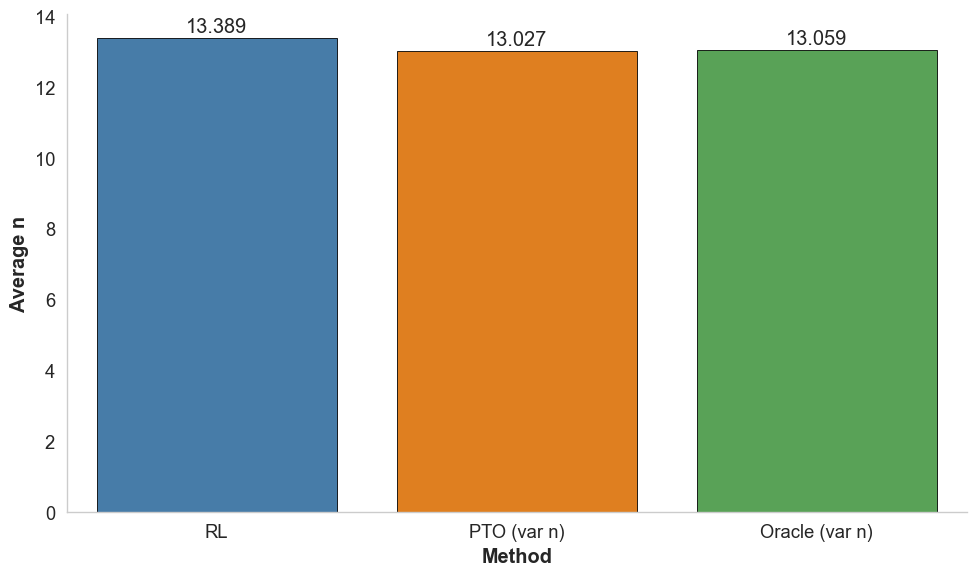

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


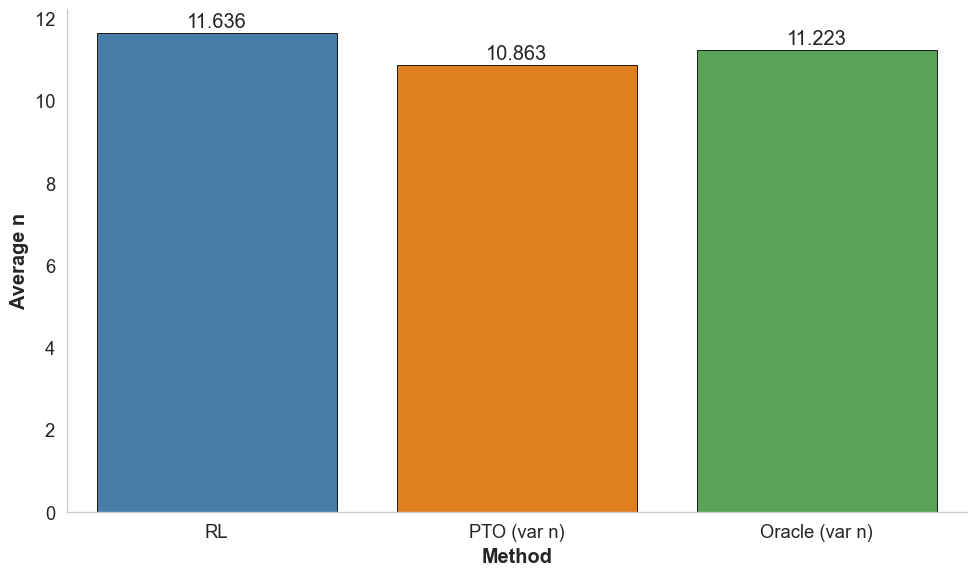

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


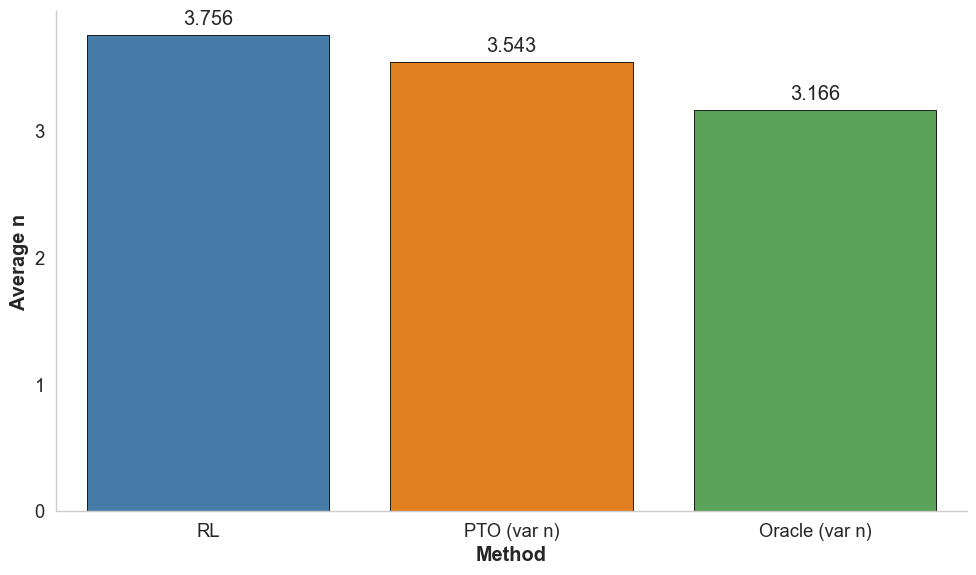

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


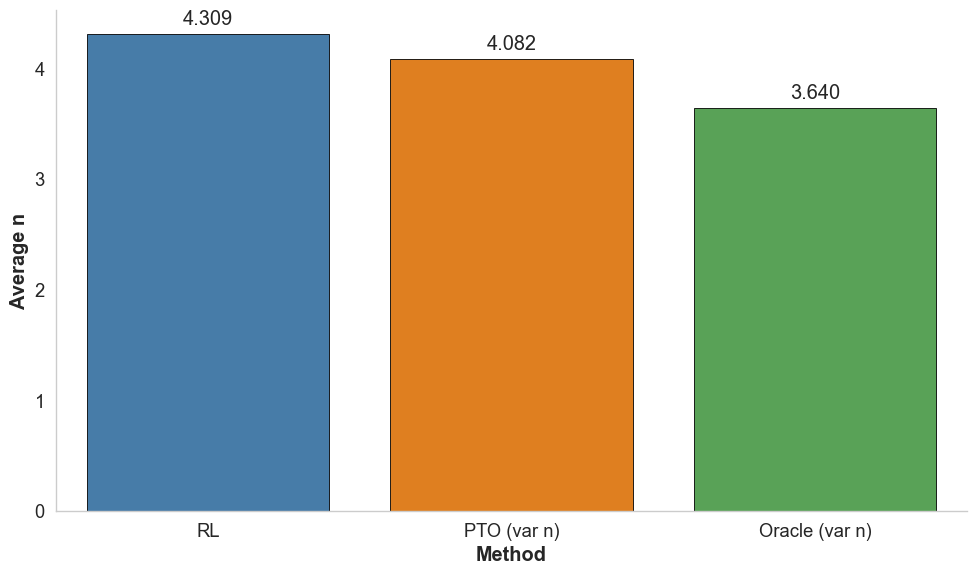

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


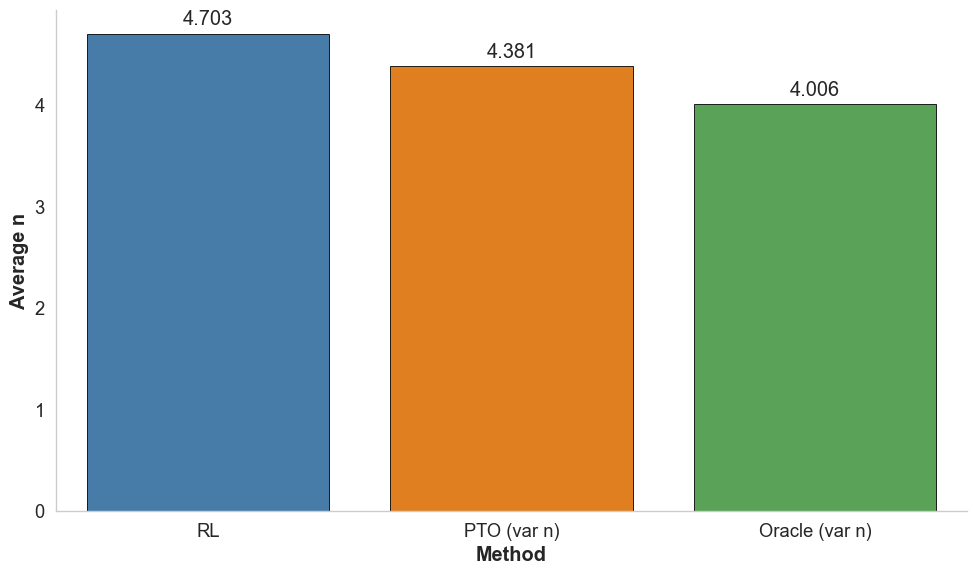

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


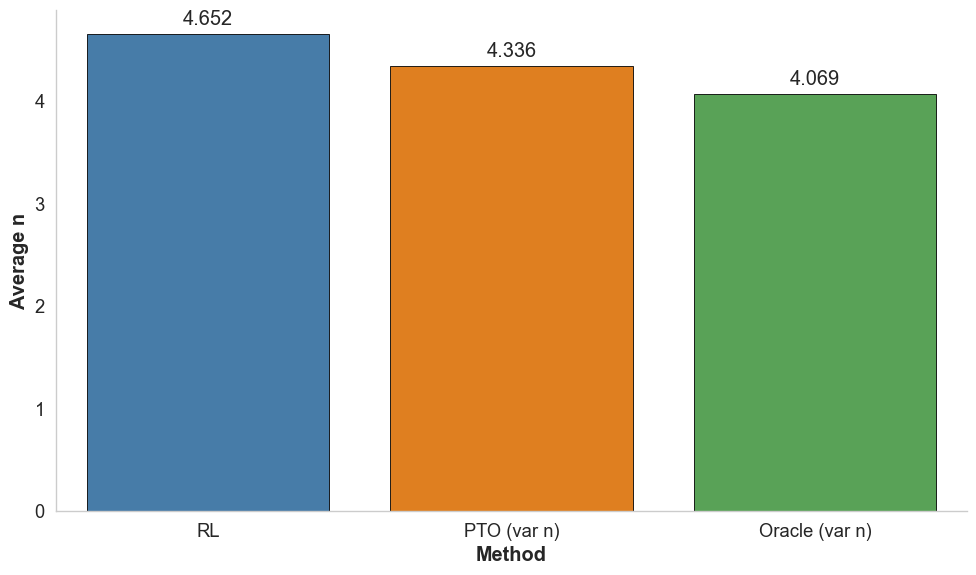

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


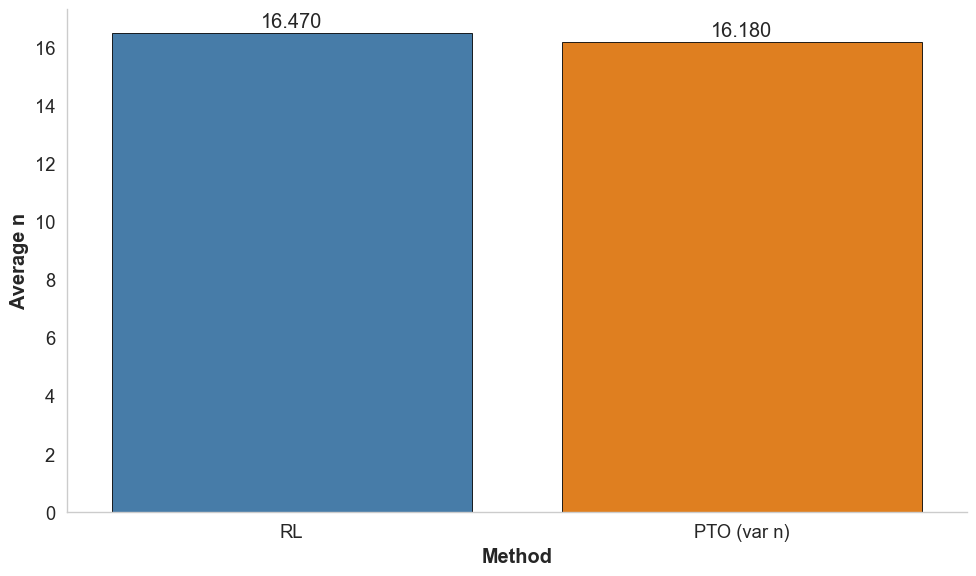

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


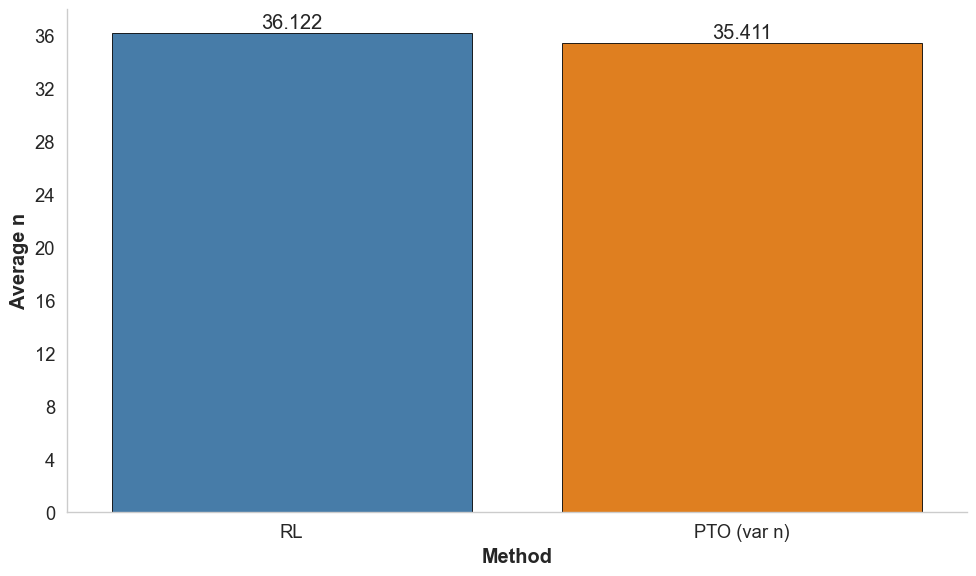

In [12]:
for row in observed_n_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(observed_n_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    observed_ns = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average n')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(observed_ns):
        ax.text(i, v + 0.05, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
    
    file_name = f'observed_n_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Obeserved n Compiled plot

,Test Name,Method,Average n
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,5.3212
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,8.2641
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,9.5677
3,high beta from 3 to 5 with uniform travel time,PPO,8.3593
4,low alpha from 0.1 to 1.0 with low travel time,PPO,7.1621


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_72037/3614390952.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


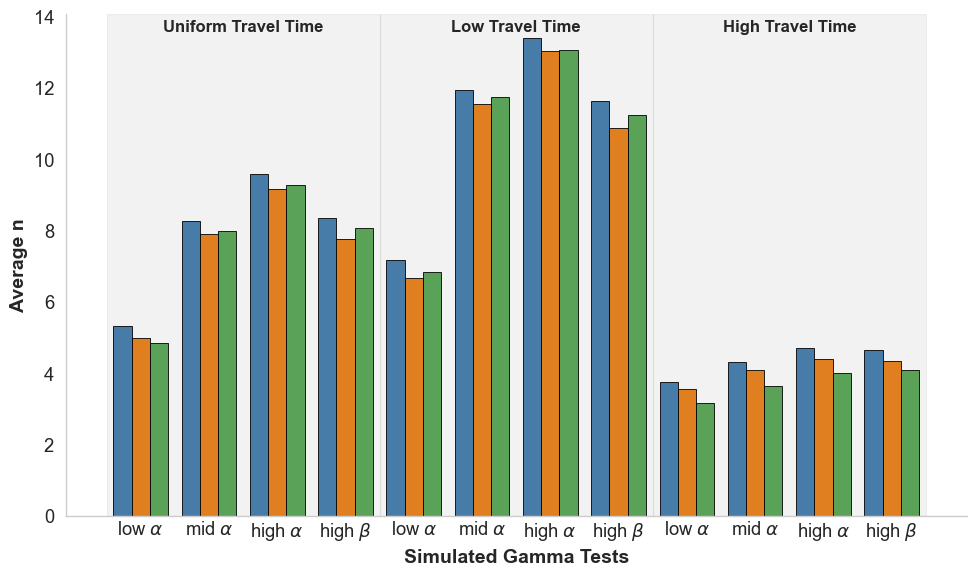

In [13]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
observed_n_results_df_melted = observed_n_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average n'
)
display(observed_n_results_df_melted.head())
observed_n_results_df_melted = observed_n_results_df_melted[observed_n_results_df_melted['Test Name'].str.contains('with', na=False)]
sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=observed_n_results_df_melted,
    x='Test Name',
    y='Average n',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)

ax.set_ylabel('Average n', fontdict={'size': 14})
ax.set_xlabel('Simulated Gamma Tests', fontdict={'size': 14})
ax.set_xticklabels([
    r'low $\alpha$',
    r'mid $\alpha$',
    r'high $\alpha$',
    r'high $\beta$',  
] * 4)

# highlight groups: 1-4 uniform, 5-8 low, 9-12 high
group_spans = [
    (-0.5, 3.5, 'Uniform Travel Time'),
    (3.5, 7.5, 'Low Travel Time'),
    (7.5, 11.5, 'High Travel Time'),
]
for xmin, xmax, label in group_spans:
    ax.axvspan(xmin, xmax, color='grey', alpha=0.1, zorder=0)
    ax.text((xmin + xmax) / 2, ax.get_ylim()[1]*0.96, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')



ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]

# legend = ax.legend(handles, mapped_labels, title='Method')
# remove legend
_current_legend = ax.get_legend()
if _current_legend is not None:
    _current_legend.remove()

plt.tight_layout()

plt.savefig(methods.file_path('observed_n_comparison_compiled.png', dir_name='figures'))
plt.show()



## u* Comparision with alpha and beta

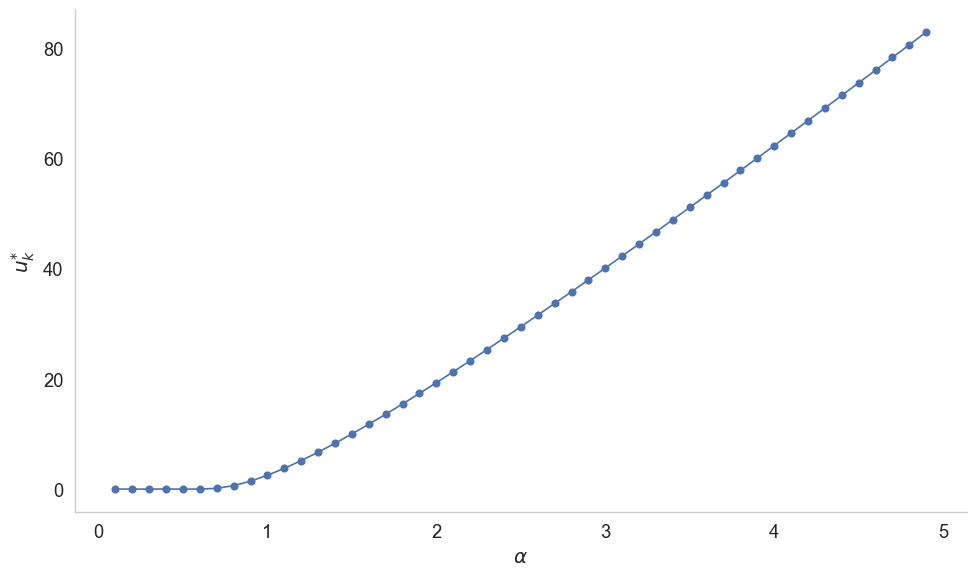

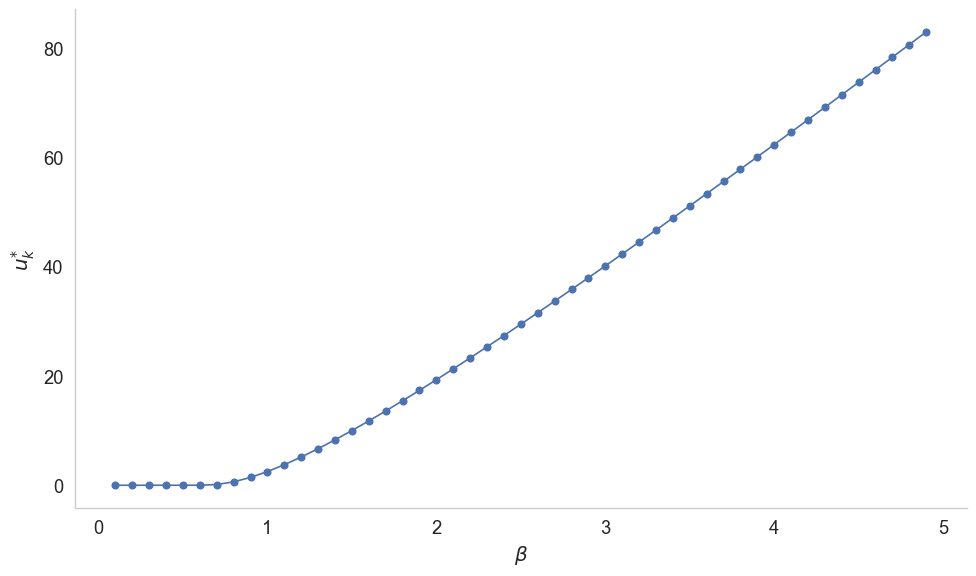

In [14]:
# u* vs alpha plot
config = {
    'k': 10,
    'alpha_range': np.arange(0.1, 5, 0.1).tolist(),
    'beta': 2,
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(alpha, config['beta'], config['k'], config['h'], config['c']) for alpha in config['alpha_range']]

# plot u* vs alpha
plt.figure(figsize=(10, 6))
plt.plot(config['alpha_range'], u_values, marker='o')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_alpha'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_alpha.png', dir_name='figures'))
plt.show()


# u* vs beta plot
config = {
    'k': 10,
    'alpha': 2,
    'beta_range': np.arange(0.1, 5, 0.1).tolist(),
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(config['alpha'], beta, config['k'], config['h'], config['c']) for beta in config['beta_range']]
# plot u* vs beta
plt.figure(figsize=(10, 6))
plt.plot(config['beta_range'], u_values, marker='o')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_beta'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_beta.png', dir_name='figures'))
plt.show()


## Plot travel time distributions

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9f469_10K.pkl



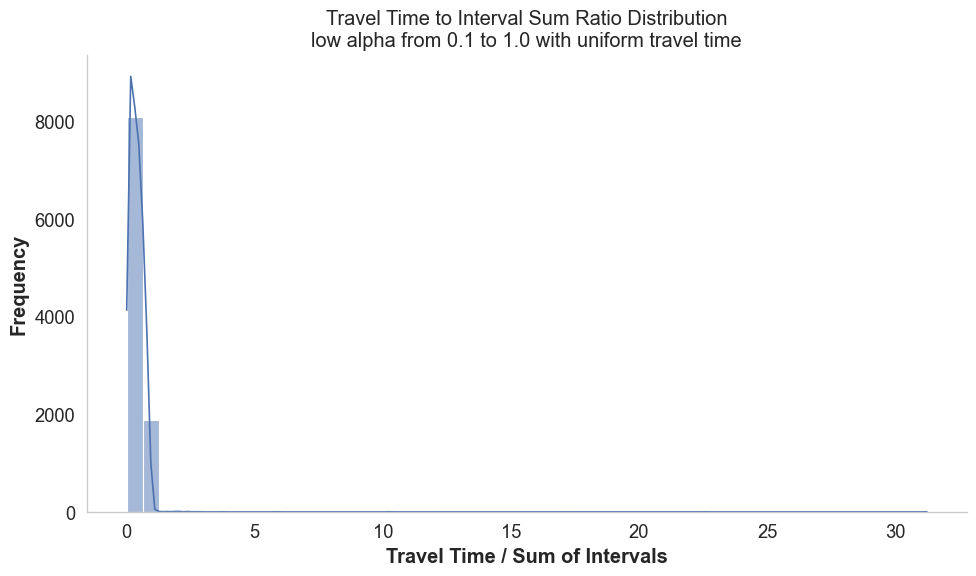

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/8b77a_10K.pkl



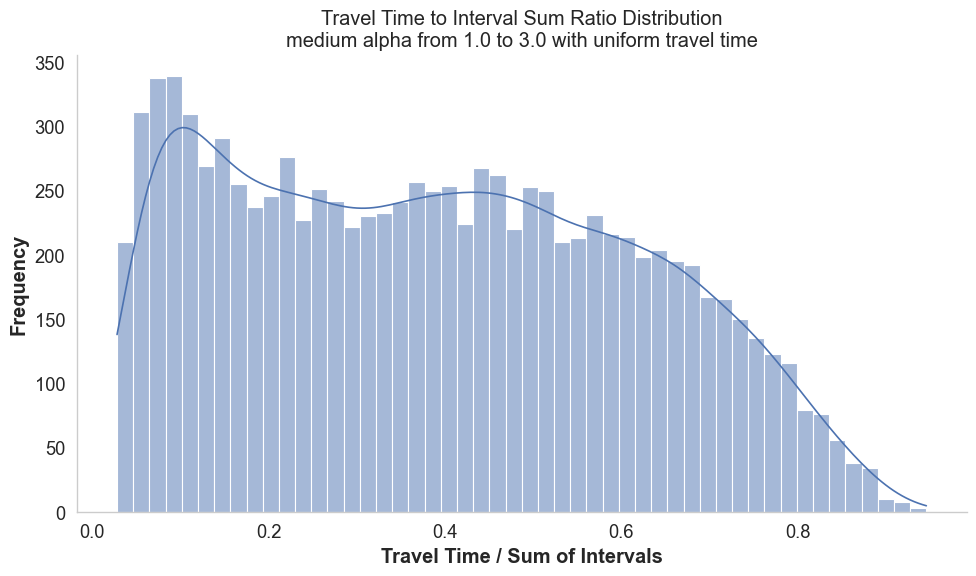

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ffd47_10K.pkl



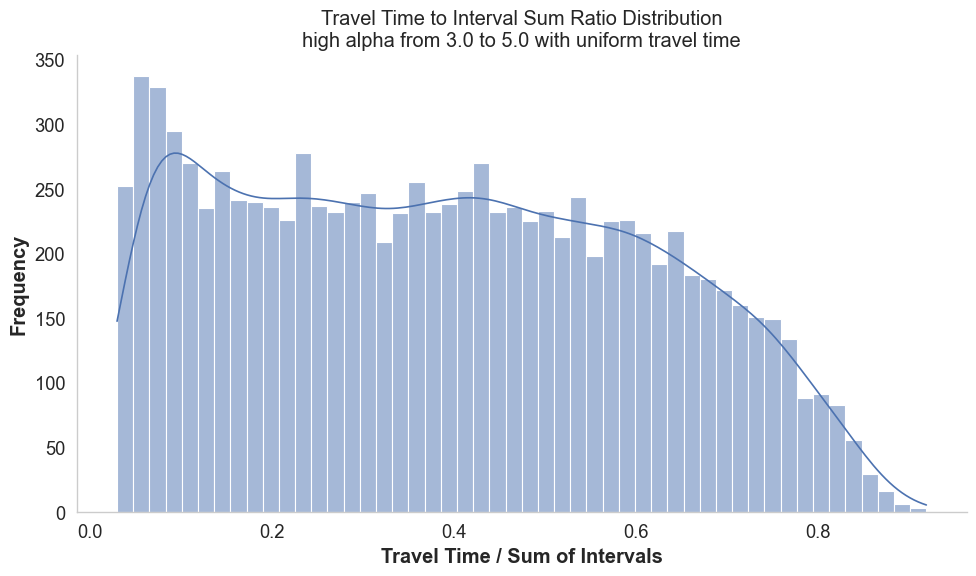

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/c77a2_10K.pkl



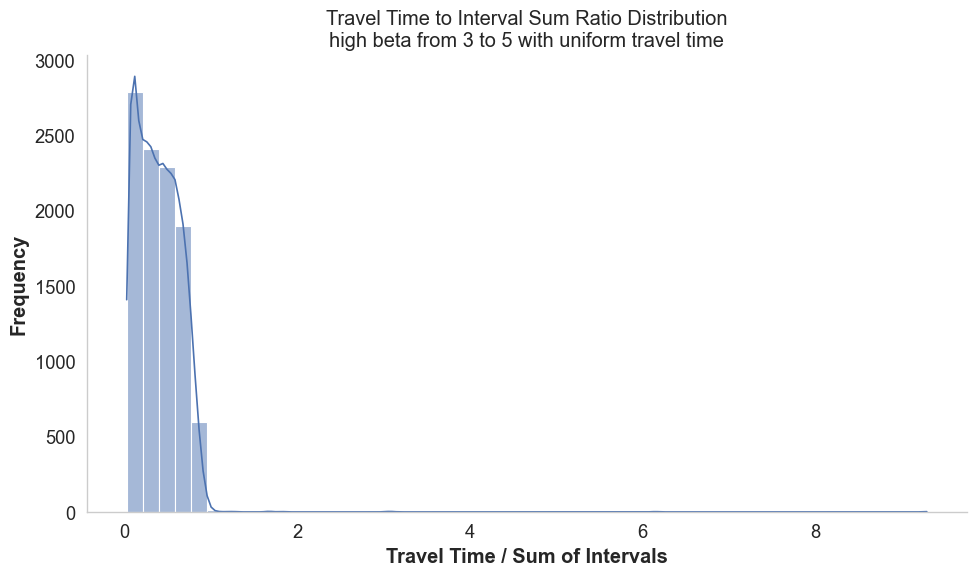

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/81641_10K.pkl



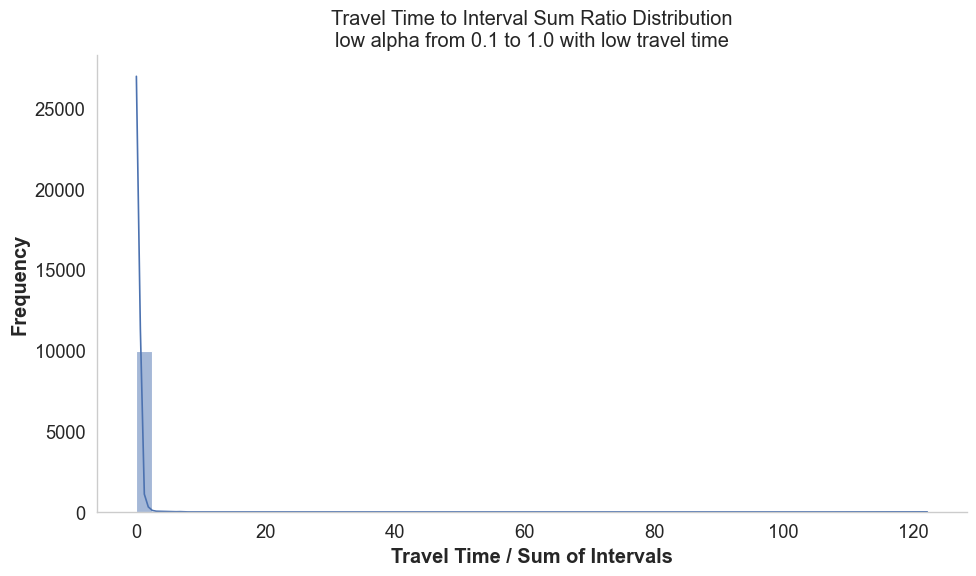

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0c4e9_10K.pkl



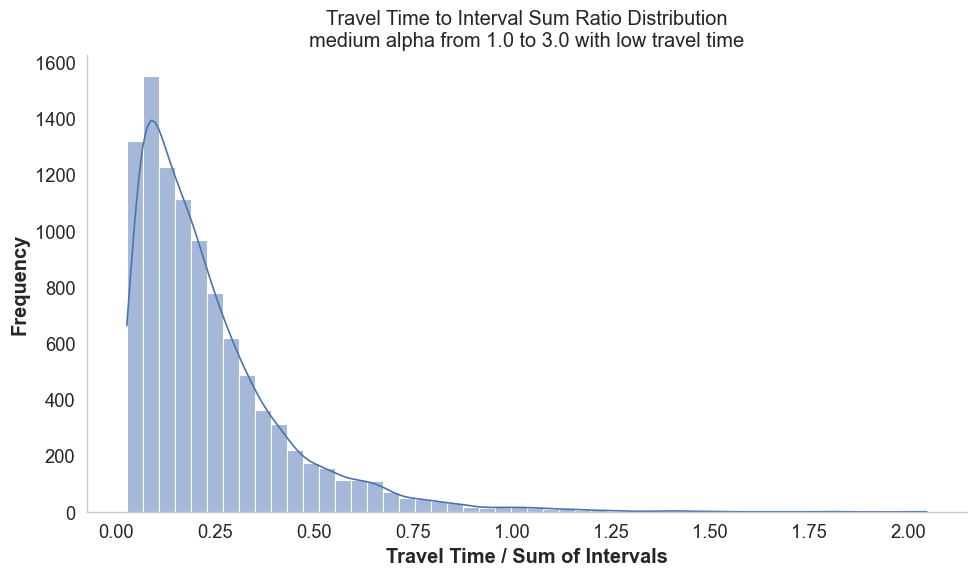

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ad796_10K.pkl



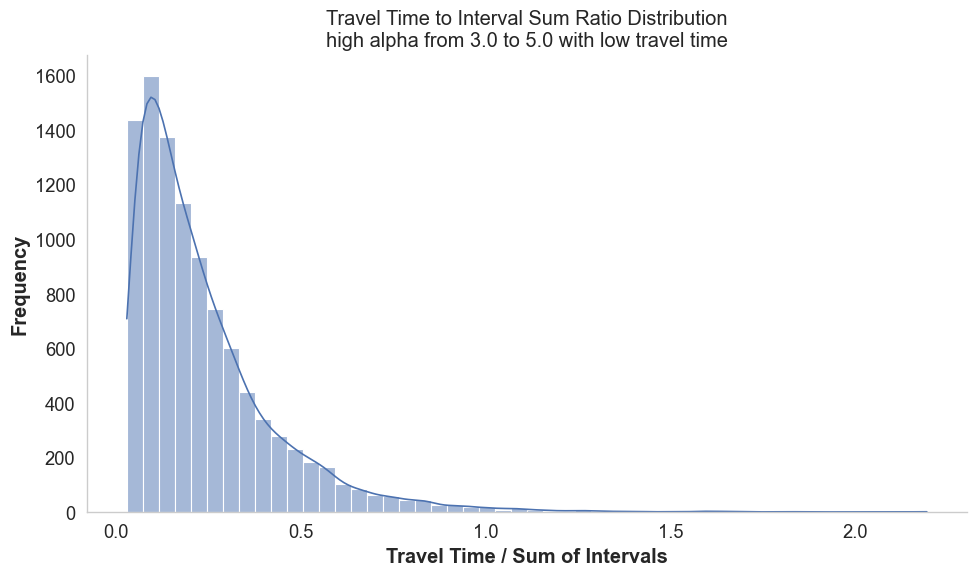

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/e425c_10K.pkl



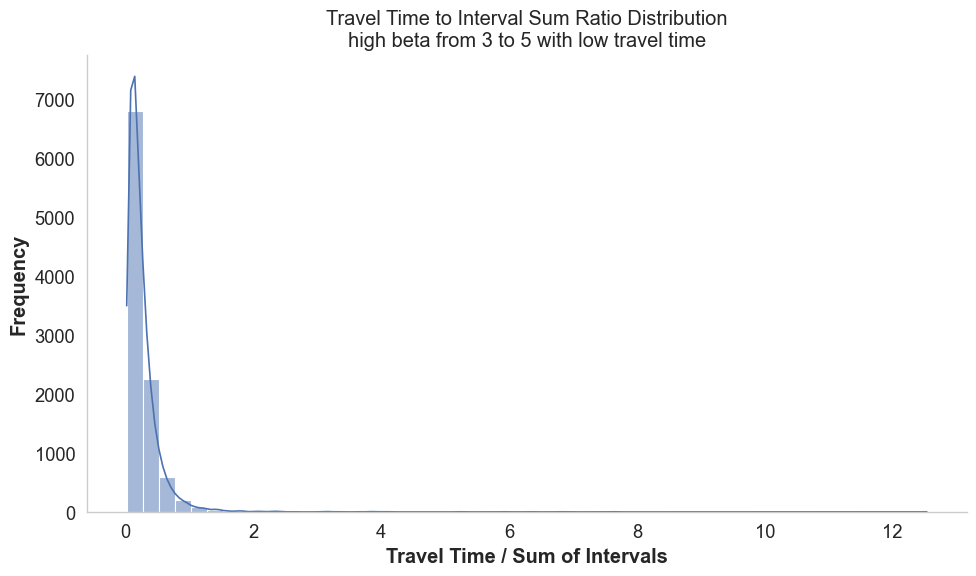

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0b349_10K.pkl



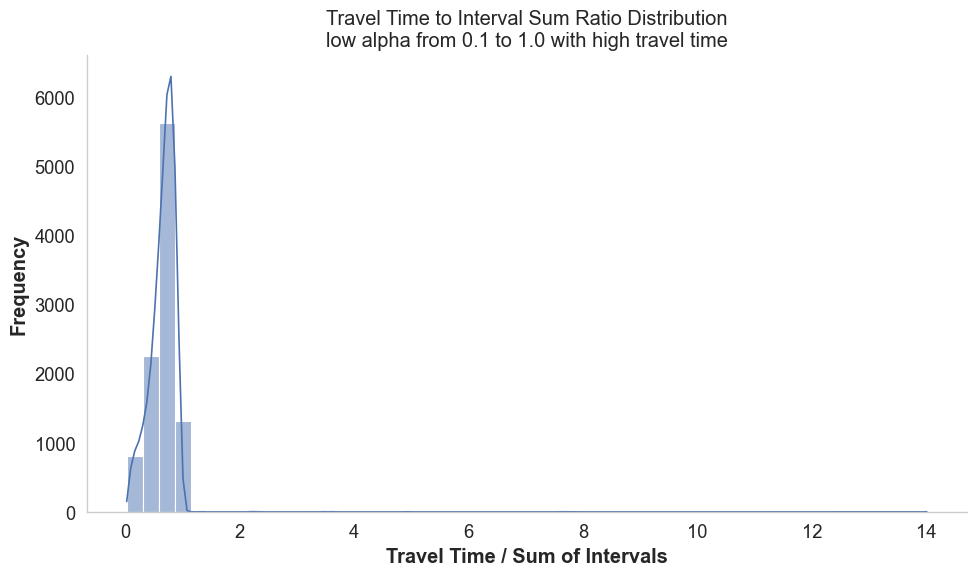

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f2aec_10K.pkl



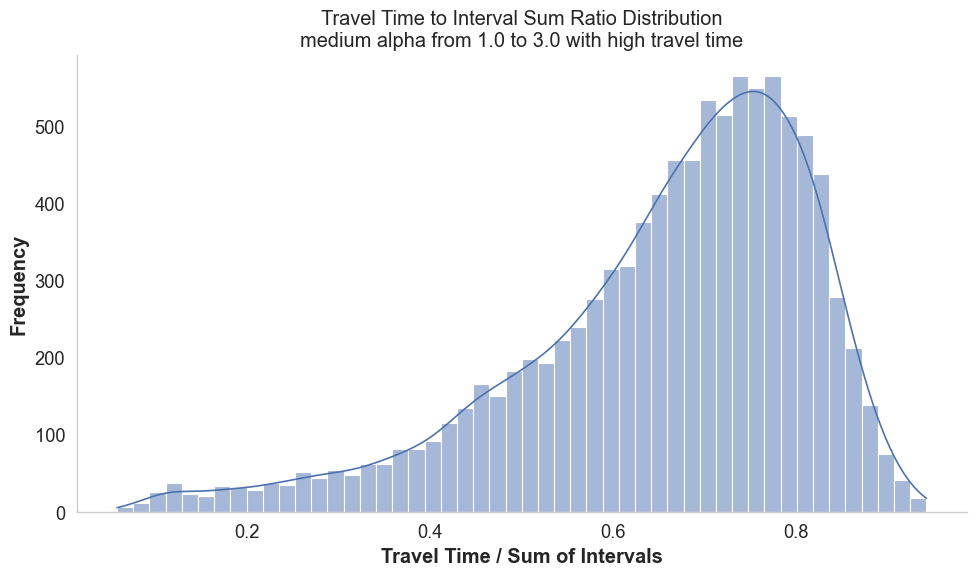

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/4556d_10K.pkl



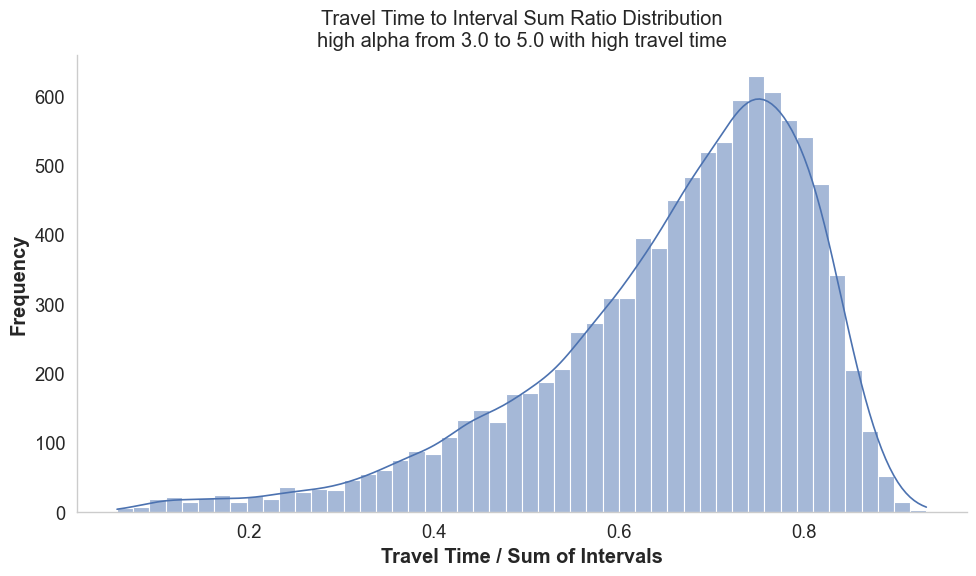

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/319b8_10K.pkl



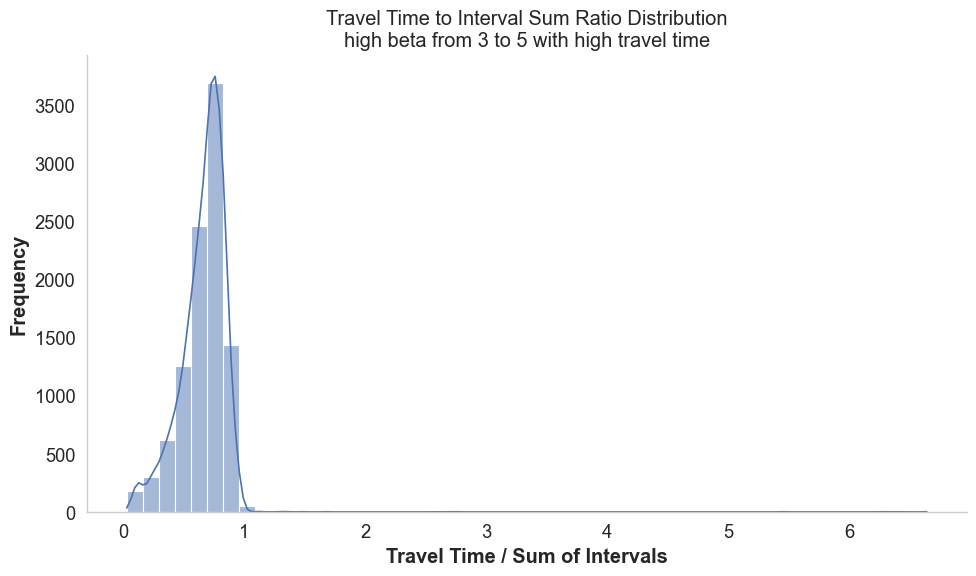

In [20]:
for test_name, config in sim_tests.items():
    
    test_df_path = generate_data.generate(config=config, row_count=10_000)
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    travel_times = test_df['travel_time'].values
    interval_sum = list(map(sum, test_df['intervals']))
    
    zip_data = list(zip(travel_times, interval_sum))
    
    # ratio of travel time to interval sum
    ratios = [tt / isum if isum > 0 else 0 for tt, isum in zip_data]
    plt.figure(figsize=(10, 6))
    sns.histplot(ratios, bins=50, kde=True)
    plt.xlabel('Travel Time / Sum of Intervals')
    plt.ylabel('Frequency')
    plt.title(f'Travel Time to Interval Sum Ratio Distribution\n{test_name}')
    plt.grid()
    sns.despine()
    plt.tight_layout()
    plt.show()
    